In [56]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm  

In [57]:
U = lambda x,y: -10*np.exp(-1./20.*( (x-10)**2 + (y)**2) ) \
                -5*np.exp(-1./20.*( (x+10)**2 + (y-5)**2) ) \
                -5*np.exp(-1./20.*( (x+10)**2 + (y+5)**2) ) \
                -5*np.exp(-1./10.*( (x)**2 + (y-5)**2 ) ) \
                +5*np.exp(-1./10.*( (y)**2 ) ) \
                -5*np.exp(-1./10.*( (x)**2 + (y+5)**2 ) )

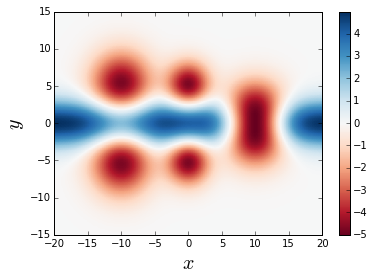

In [168]:
fig, ax = plt.subplots()
x = np.arange(-20.,20.,0.2)
y = np.arange(-15.,15.,0.2)
X,Y = np.meshgrid(x, y)
Z = U(X,Y)
p = ax.pcolor(X, Y, Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max())
plt.ylabel(r'$y$',fontsize=20)
plt.xlabel(r'$x$', fontsize = 20)
cb = fig.colorbar(p, ax=ax)

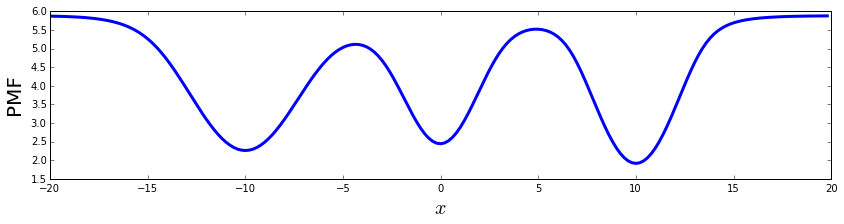

In [64]:
plt.figure(figsize=(14,3))
plt.subplot(1,1,1)
x = np.arange(-20.,20.,0.2)
y = np.arange(-20.,20.,0.2)
X,Y = np.meshgrid(x, y)
Z = np.exp(-1/0.6*U(X,Y))
F = [np.sum(Z[:,i]) for i in range(len(x))]
plt.plot(x,-0.6*np.log(F/np.sum(F)),lw=3)
plt.ylabel(r'PMF',fontsize=20)
plt.xlabel(r'$x$', fontsize = 20)
plt.xlim(-20,20.)
plt.show()

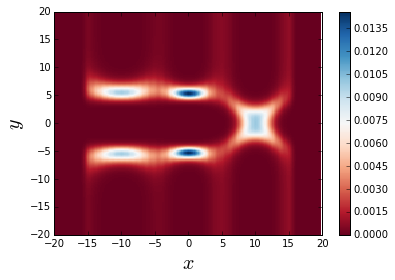

In [90]:
x = np.arange(-20.,20.,0.2)
y = np.arange(-20.,20.,0.2)
X,Y = np.meshgrid(x, y)
k = lambda x,y: np.array([0.5*2.5 * (x-c)**2 for c in range(-15,16,1)])
nrep = 31
U2 = np.array([U(X,Y) + k(X,Y)[i,:] for i in range(nrep)])
Z = np.exp(-1/0.6*(U2))
Z = np.sum([Z[i,:]/np.sum(Z[i,:]) for i in range(nrep)], axis=0)

fig, ax = plt.subplots()
p = ax.pcolor(X, Y, Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max())
plt.ylabel(r'$y$',fontsize=20)
plt.xlabel(r'$x$', fontsize = 20)
cb = fig.colorbar(p, ax=ax)

# simulation data

In [231]:
import pandas as pd
trajs = [pd.read_csv('log.%d' % i, sep='\s+', header=None) for i in range(31)]

In [232]:
trajs_concatenated = pd.concat(trajs).as_matrix()

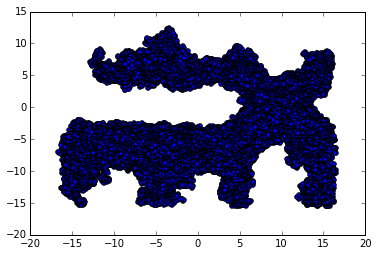

In [233]:
plt.scatter(trajs_concatenated[:,0], trajs_concatenated[:,1])

In [234]:
hist,xbins,ybins = np.histogram2d(trajs_concatenated[:,0], trajs_concatenated[:,1], bins=(50,50), range=((-15,15),(-15,15)), normed=True)

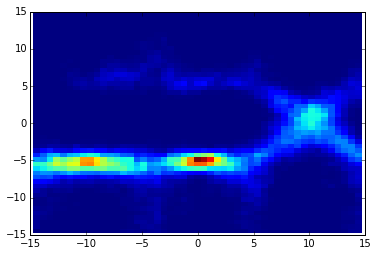

In [235]:
xcenter = (xbins[:-1] + xbins[1:]) / 2
ycenter = (ybins[:-1] + ybins[1:]) / 2
X,Y = np.meshgrid(xcenter, ycenter)
plt.pcolor(X,Y,hist.T)

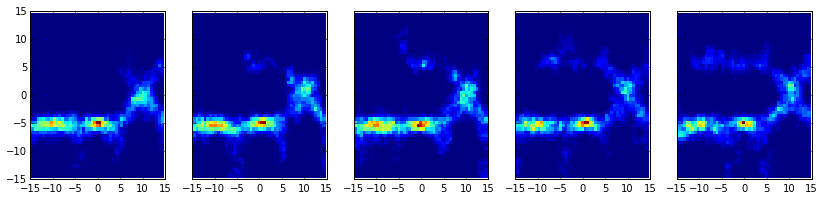

In [236]:
fig, ax = plt.subplots(1,5, sharey=True, figsize=(14,3))
for i in range(5):
    subset = pd.concat([x[i*2000:(i+1)*2000] for x in trajs]).as_matrix()
    hist,xbins,ybins = np.histogram2d(subset[:,0], subset[:,1], bins=(50,50), range=((-15,15),(-15,15)), normed=True) 
    ax[i].pcolor(X,Y,hist.T)

# free energy with WHAM

In [253]:
def wham(nb_data, TOP, nwin, nbin, V1, beta, F=None, fifreq=500):
    icycle = 1
    niter = 5000
    kbt = 1 / beta
    tol = 1e-6
    rho = np.zeros(nbin)
    if F is None: F = np.zeros(nwin)
    F2 = np.zeros(nwin)
    while icycle < niter:
        for j in range(nbin):
            BOT = np.sum(nb_data * np.exp(beta*(F-V1[:,j])))
            rho[j] = TOP[j] / BOT
            F2 = F2 + rho[j]*np.exp(-beta*V1[:,j])

        converged = True
        F2 = -kbt*np.log(F2)
        F2 = F2 -np.min(F2)
        diff = np.max(np.abs(F2 - F))

        if diff > tol: converged = False
        #print 'round = ', icycle, 'diff = ', diff
        icycle += 1

        if ( fifreq != 0 and icycle % fifreq == 0 ) or ( icycle == niter or converged ):
            print ('round = ', icycle, 'diff = ', diff)
            #open(fff_filename, 'w').write("%8i %s\n" % (icycle, " ".join(["%8.3f" % f for f in F2]))) 
            if icycle == niter or converged: break

        F = F2
        F2 = np.zeros(nwin)

    return F2, rho

In [246]:
delta = 0.5
nwin = 31
xmax, xmin = 15, -15
nbin = int((xmax-xmin+0.5*delta)/delta)
TOP = np.zeros(nbin, dtype=np.int32)
BOT = np.zeros(nbin)
V1 = np.zeros((nwin, nbin))
x1 = lambda j: -15 + delta / 2 + j * delta
cx1 = [-15+j for j in range(nwin)]
nb_data = np.zeros(nwin, dtype=np.int)

trajs_concatenated = pd.concat(trajs)
for i in range(nwin):
    xbins = [xmin+j*delta for j in range(nbin+1)]
    hist, edges = np.histogram(trajs_concatenated[trajs_concatenated[2] == i].as_matrix()[:,0], bins=xbins, range=(xmin,xmax))
    nb_data[i] = np.sum(hist)
    for j in range(nbin):
        V1[i,j] = 0.5*2.5*(x1(j) - cx1[i])**2
        TOP[j] += hist[j]
F, rho = wham(nb_data, TOP, nwin, nbin, V1, 1/0.6)

round =  500 diff =  7.58188053362e-05
round =  1000 diff =  2.21185659735e-05
round =  1500 diff =  6.13277213857e-06
round =  2000 diff =  1.69746738399e-06
round =  2206 diff =  9.99904946841e-07


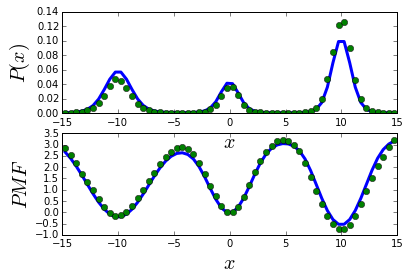

In [247]:
plt.figure()
plt.subplot(2,1,1)
x = np.array([x1(i) for i in range(nbin)])
y = np.arange(-20.,20.,0.2)
X,Y = np.meshgrid(x, y)
Z = np.exp(-1/0.6*U(X,Y))

rho = rho/np.sum(rho)
F = [np.sum(Z[:,i]) for i in range(len(x))]
plt.plot(x,F/np.sum(F),lw=3)
plt.plot(x,rho,'o',lw=3)
plt.ylabel(r'$P(x)$',fontsize=20)
plt.xlabel(r'$x$', fontsize = 20)
plt.xlim(xmin,xmax)

plt.subplot(2,1,2)
plt.plot(x, -0.6*np.log(F/F[int(nbin/2)]), lw=3)
plt.plot(x, -0.6*np.log(rho/rho[nbin/2]), 'o', lw=3)
plt.ylabel(r'$PMF$',fontsize=20)
plt.xlabel(r'$x$', fontsize = 20)
plt.show()

In [254]:
rho = []
for k in range(5):
    TOP = np.zeros(nbin, dtype=np.int32)
    for i in range(nwin):
        xbins = [xmin+j*delta for j in range(nbin+1)]
        sorted_trajs = trajs_concatenated[trajs_concatenated[2] == i].as_matrix()[:,0]
        block = int(len(sorted_trajs)/5)
        hist, edges = np.histogram(sorted_trajs[k*block:(k+1)*block], bins=xbins, range=(xmin,xmax))
        nb_data[i] = np.sum(hist)
        for j in range(nbin):
            V1[i,j] = 0.5*2.5*(x1(j) - cx1[i])**2
            TOP[j] += hist[j]
    F, rho0 = wham(nb_data, TOP, nwin, nbin, V1, 1/0.6, fifreq=10000)
    rho.append(rho0)

round =  3158 diff =  9.99799149248e-07
round =  2926 diff =  9.9884195226e-07
round =  3083 diff =  9.98503947969e-07
round =  3019 diff =  9.97900782451e-07
round =  2891 diff =  9.98418893339e-07


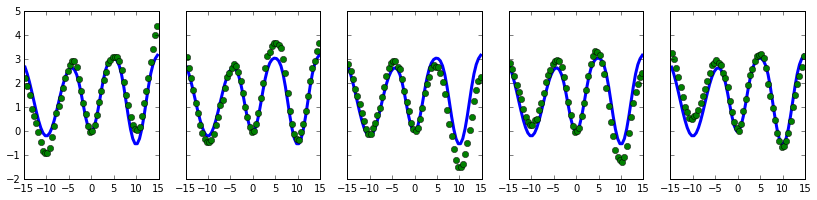

In [259]:
fig, ax = plt.subplots(1,5, sharey=True, figsize=(14,3))
x = np.array([x1(i) for i in range(nbin)])
y = np.arange(-20.,20.,0.2)
X,Y = np.meshgrid(x, y)
Z = np.exp(-1/0.6*U(X,Y))
F = [np.sum(Z[:,i]) for i in range(len(x))]
for i in range(5):
    ax[i].plot(x, -0.6*np.log(F/F[int(nbin/2)]), lw=3)
    ax[i].plot(x, -0.6*np.log(rho[i]/rho[i][nbin/2]), 'o', lw=3)